## import

In [3]:
import torch
import torchvision
import torch.nn.functional as F
from torch import nn, optim
from torchvision import transforms, datasets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

## epoch, batch size 정의

In [6]:
EPOCH = 10
BATCH_SIZE = 64
USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
print("Device is :", DEVICE)

Device is : cuda


## 학습용 데이터 셋 정의

In [7]:
trainset = datasets.FashionMNIST(
    root = './.data/',
    train = True,
    download = True,
    transform = transforms.ToTensor()
)

train_loader = torch.utils.data.DataLoader(
    dataset = trainset,
    batch_size = BATCH_SIZE,
    shuffle = True,
    num_workers = 2
)

## autoencoder 모듈 정의

In [17]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 12),
            nn.ReLU(),
            nn.Linear(12, 3),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(),
            nn.Linear(12, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid(),
        )
        
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

## model과 optimizer 함수 정의

In [18]:
autoencoder = Autoencoder().to(DEVICE)
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=0.005)
criterion = nn.MSELoss()

## 잡음 추가 함수

In [19]:
def add_noise(img):
    noise = torch.randn(img.size()) * 0.2
    noisy_img = img + noise
    return noisy_img

## train 함수

In [20]:
def train(autoencoder, train_loader):
    autoencoder.train()
    avg_loss = 0
    for step, (x, label) in enumerate(train_loader):
        x = add_noise(x);
        x = x.view(-1, 28*28).to(DEVICE)
        y = x.view(-1, 28*28).to(DEVICE)
        
        label = label.to(DEVICE)
        encoded, decoded = autoencoder(x)
        
        loss = criterion(decoded, y)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        avg_loss += loss.item()
    return avg_loss / len(train_loader)

## 학습

In [21]:
for epoch in range(1, EPOCH+1):
    loss = train(autoencoder, train_loader)
    print("[Epoch {}] loss:{}".format(epoch, loss))

[Epoch 1] loss:0.08166984440103522
[Epoch 2] loss:0.07290938716612137
[Epoch 3] loss:0.07186065833451652
[Epoch 4] loss:0.07076540038879238
[Epoch 5] loss:0.06819625528477656
[Epoch 6] loss:0.06660826789783135
[Epoch 7] loss:0.06583921853969218
[Epoch 8] loss:0.06517650651286787
[Epoch 9] loss:0.06479920156554246
[Epoch 10] loss:0.06451203953276184


## 테스트용 데이터 셋 정의


In [23]:
testset = datasets.FashionMNIST(
    root = './.data/',
    train = False, 
    download = True,
    transform = transforms.ToTensor()
)

## 테스트할 이미지 준비

In [36]:
sample_data = testset.data[0].view(-1, 28*28)
sample_data = sample_data.type(torch.FloatTensor)/255.

## 이미지를 오염 시켜 모델에 적용

In [37]:
original_x = sample_data[0]
noisy_x = add_noise(original_x).to(DEVICE)
_, recovered_x = autoencoder(noisy_x)

## 결과 확인 ( 이미지 시각화 )

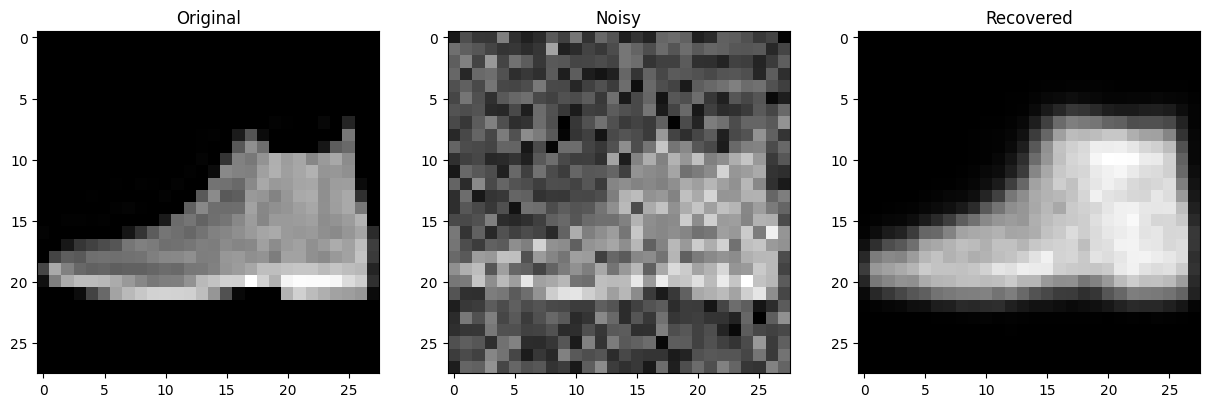

In [38]:
f, a = plt.subplots(1, 3, figsize=(15, 15))

original_img = np.reshape(original_x.to("cpu").data.numpy(), (28, 28))
noisy_img = np.reshape(noisy_x.to("cpu").data.numpy(), (28, 28))
recoverd_img = np.reshape(recovered_x.to("cpu").data.numpy(), (28, 28))

a[0].set_title('Original')
a[0].imshow(original_img, cmap='gray')

a[1].set_title('Noisy')
a[1].imshow(noisy_img, cmap='gray')

a[2].set_title('Recovered')
a[2].imshow(recoverd_img, cmap='gray')

plt.show()